In [14]:
!pip install -q opencv-contrib-python


Mount Google Drive

In [15]:
from google.colab import drive
drive.mount("/content/drive")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Khai báo đường dẫn dataset

In [16]:
import os
DATASET_DIR = "/content/drive/MyDrive/LBPH_DATASET"

TRAIN_DIR = os.path.join(DATASET_DIR, "train")
VAL_DIR   = os.path.join(DATASET_DIR, "val")
TEST_DIR  = os.path.join(DATASET_DIR, "test")

LABEL_MAP_PATH = os.path.join(DATASET_DIR, "label_map.json")


Hàm load dataset

In [17]:
def load_lbph_data(base_dir):
    faces = []
    labels = []

    for label in sorted(os.listdir(base_dir), key=int):
        label_dir = os.path.join(base_dir, label)
        if not os.path.isdir(label_dir):
            continue

        for img_name in os.listdir(label_dir):
            img_path = os.path.join(label_dir, img_name)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            if img is None:
                continue

            faces.append(img)
            labels.append(int(label))

    return faces, np.array(labels)


Load train / val / test

In [18]:
import cv2
import numpy as np
import json
train_faces, train_labels = load_lbph_data(TRAIN_DIR)
val_faces,   val_labels   = load_lbph_data(VAL_DIR)
test_faces,  test_labels  = load_lbph_data(TEST_DIR)

print("Train:", len(train_faces))
print("Val:  ", len(val_faces))
print("Test: ", len(test_faces))


Train: 447
Val:   149
Test:  149


Khởi tạo & train LBPH

In [19]:
model = cv2.face.LBPHFaceRecognizer_create(
    radius=1,
    neighbors=8,
    grid_x=8,
    grid_y=8
)

model.train(train_faces, train_labels)
print(" LBPH trained")


 LBPH trained


Evaluate trên VAL (tune threshold)

In [20]:
def evaluate_lbph(model, faces, labels, threshold):
    correct = 0
    total = 0

    for img, true_label in zip(faces, labels):
        pred_label, conf = model.predict(img)

        if conf < threshold:
            total += 1
            if pred_label == true_label:
                correct += 1

    acc = correct / total if total > 0 else 0
    return acc, total


Tìm threshold tốt nhất bằng VAL

In [21]:
def evaluate_lbph_with_coverage(model, faces, labels, threshold):
    correct = 0
    used = 0

    for img, true_label in zip(faces, labels):
        pred, conf = model.predict(img)
        if conf < threshold:
            used += 1
            if pred == true_label:
                correct += 1

    acc = correct / used if used > 0 else 0
    coverage = used / len(faces)
    return acc, coverage, used


thresholds = range(40, 121, 5)

best_thr = None
best_score = -1

MIN_COVERAGE = 0.3   # 🔥 RẤT QUAN TRỌNG

for thr in thresholds:
    acc, cov, used = evaluate_lbph_with_coverage(
        model, val_faces, val_labels, thr
    )

    print(f"thr={thr:3d} | acc={acc:.3f} | cov={cov:.3f} | used={used}")

    # chỉ xét threshold có coverage đủ lớn
    if cov >= MIN_COVERAGE:
        score = acc * cov   # trade-off score

        if score > best_score:
            best_score = score
            best_thr = thr

print("\n Best threshold:", best_thr)
print(" Trade-off score:", best_score)


thr= 40 | acc=1.000 | cov=0.013 | used=2
thr= 45 | acc=0.267 | cov=0.201 | used=30
thr= 50 | acc=0.257 | cov=0.497 | used=74
thr= 55 | acc=0.248 | cov=0.678 | used=101
thr= 60 | acc=0.213 | cov=0.852 | used=127
thr= 65 | acc=0.206 | cov=0.913 | used=136
thr= 70 | acc=0.199 | cov=0.946 | used=141
thr= 75 | acc=0.192 | cov=0.980 | used=146
thr= 80 | acc=0.192 | cov=0.980 | used=146
thr= 85 | acc=0.189 | cov=0.993 | used=148
thr= 90 | acc=0.188 | cov=1.000 | used=149
thr= 95 | acc=0.188 | cov=1.000 | used=149
thr=100 | acc=0.188 | cov=1.000 | used=149
thr=105 | acc=0.188 | cov=1.000 | used=149
thr=110 | acc=0.188 | cov=1.000 | used=149
thr=115 | acc=0.188 | cov=1.000 | used=149
thr=120 | acc=0.188 | cov=1.000 | used=149

 Best threshold: 65
 Trade-off score: 0.18791946308724833


Đánh giá cuối trên TEST

In [22]:
test_acc, test_used = evaluate_lbph(
    model,
    test_faces,
    test_labels,
    best_thr
)

print("🎯 TEST accuracy:", test_acc)
print("Images used:", test_used)
print("Used:", test_used, "/", len(test_faces))


🎯 TEST accuracy: 0.13432835820895522
Images used: 134
Used: 134 / 149


Confusion stats

In [23]:
from collections import Counter

errors = Counter()

for img, true_label in zip(test_faces, test_labels):
    pred_label, conf = model.predict(img)
    if conf < best_thr and pred_label != true_label:
        errors[(true_label, pred_label)] += 1

print("Top confusions:")
for k, v in errors.most_common(10):
    print(k, v)


Top confusions:
(np.int64(0), 71) 1
(np.int64(1), 67) 1
(np.int64(2), 80) 1
(np.int64(4), 134) 1
(np.int64(6), 78) 1
(np.int64(7), 134) 1
(np.int64(8), 28) 1
(np.int64(9), 13) 1
(np.int64(10), 91) 1
(np.int64(12), 39) 1


Lưu model + metadata

In [24]:
OUT_DIR = "/content/drive/MyDrive/LBPH_MODEL"
os.makedirs(OUT_DIR, exist_ok=True)

MODEL_PATH = os.path.join(OUT_DIR, "lbph_model.xml")
META_PATH  = os.path.join(OUT_DIR, "metadata.json")

model.save(MODEL_PATH)

metadata = {
    "threshold": best_thr,
    "val_accuracy": best_acc,
    "test_accuracy": test_acc,
    "num_classes": len(set(train_labels)),
    "train_images": len(train_faces)
}

with open(META_PATH, "w") as f:
    json.dump(metadata, f, indent=2)

print(" Model saved:", MODEL_PATH)


 Model saved: /content/drive/MyDrive/LBPH_MODEL/lbph_model.xml


Test nhanh 1 ảnh

True: 116
Pred: 116
Conf: 50.77563443228037


(np.float64(-0.5), np.float64(199.5), np.float64(199.5), np.float64(-0.5))

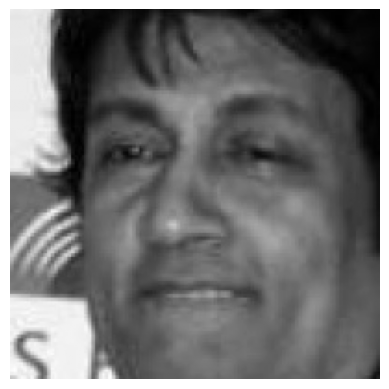

In [25]:
idx = np.random.randint(0, len(test_faces))
img = test_faces[idx]
true_label = test_labels[idx]

pred, conf = model.predict(img)

print("True:", true_label)
print("Pred:", pred)
print("Conf:", conf)

import matplotlib.pyplot as plt
plt.imshow(img, cmap="gray")
plt.axis("off")


In [26]:
correct = 0
used = 0

for img, true_label in zip(test_faces, test_labels):
    pred, conf = model.predict(img)

    if conf < best_thr:
        used += 1
        if pred == true_label:
            correct += 1

print("Accuracy:", correct / used if used else 0)
print("Used:", used, "/", len(test_faces))


Accuracy: 0.13432835820895522
Used: 134 / 149
